<div>
<h1 style="background-color:#82e0aa   ;padding:20px;border-radius:10px;border:3px solid #3339ff;color:#21618c  ;text-align:center; font-family: Babas; font-size: 3.0em;" > Segmentation of e-commerce website customers |Monitoring

<p style="text-align:center;"><img src="https://d2mvnyejvnd30x.cloudfront.net/uploads/2022/08/Ecossistema-Olist.png"   width="400" height="250"/></p></h1>
</div>

<a id="toc"></a>
# Table of Contents
<a id="toc"></a>
- [1. Import libraries and data](#IR)
    - [1.1 Import Libraries](#imp)
    - [1.2 Data reading](#dr)
- [2. Data Preprocessing](#dp)
    - [2.1 Basic information of data](#basic)
    - [2.2 Check for missing value](#missing)
    - [2.3 Features preview](#fp)
    - [2.3 Date Features](#2.3)
        - [2.3.1 Day and desposit](#2.3.1)
        - [2.3.2 Month and desposit](#2.3.2)
        - [2.3.3 Day and Month](#2.3.3)
    - [2.4 Numeric Features](#2.4)
        - [2.4.1 Age and desposit](#2.4.1)
        - [2.4.2 Balance and desposit](#2.4.2)
        - [2.4.3 Duration and desposit](#2.4.3)
        - [2.4.4 Campaign and desposit](#2.4.4)
        - [2.4.5 Pdays and desposit](#2.4.5)
        - [2.4.6 Previous and desposit](#2.4.6)
    - [2.5 Categorical Features](#2.5)

<a id="IR"></a>


# <h1 style="background-color:#82e0aa ;padding:18px;border-radius:10px;border:3px solid #3339ff;color:#21618c;text-align:center" >Import libraries and data</h1>


<a id="imp"></a>
## <span style="color:#33afff  ;"> Import libraries </span>

In [1]:
#builtin
import os

#data
import pandas as pd
import numpy as np
import missingno as msno
from datetime import date,timedelta
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.metrics import  adjusted_rand_score
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer,InterclusterDistance
from sklearn.preprocessing import StandardScaler,  RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

<a id="dr"></a>
## <span style="color:#33afff  ;"> Data reading </span>

In [3]:
df = pd.read_csv('olist_data.csv')

In [4]:
date_type= ["order_purchase_timestamp", "order_approved_at",  "order_delivered_customer_date", "order_delivered_carrier_date", 
             "order_estimated_delivery_date", "review_creation_date" , "review_answer_timestamp" , "shipping_limit_date"]

for col in date_type:
     df[col] = pd.to_datetime(df[col])
df.dtypes

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
customer_lat                            float64
customer_lng                            float64
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
review_id                                object
review_score                            float64
review_comment_title                     object
review_comment_message                   object
review_creation_date             datetime64[ns]
review_answer_timestamp          datetime64[ns]
payment_sequential                      

<a id="dp"></a>
# <h1 style="background-color:#82e0aa ;padding:18px;border-radius:10px;border:3px solid #3339ff;color:#21618c;text-align:center" >Monitoring</h1>


We collect the number of the needed 2018 weeks for monitoring and save it in list

In [5]:
week_selection = df[df['order_purchase_timestamp'].dt.year==2018].copy()
week_selection["purchase_week"] = week_selection["order_purchase_timestamp"].dt.isocalendar().week
weeks = list(week_selection.purchase_week.unique())
weeks.sort()
weeks = [i for i in weeks if i >10]
print(weeks)

[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]


In [6]:
#Data selection
select_F0= df[~((df['order_purchase_timestamp'].dt.isocalendar().year == 2018) & (df['order_purchase_timestamp'].dt.isocalendar().week > 10))].copy()

#Data generation for the period
F0 = select_F0.groupby("customer_unique_id").agg(recency=("order_purchase_timestamp",
                                                          lambda x: (select_F0['order_purchase_timestamp'].max() + timedelta(days=1) - x.max()).days),
                                                 frequency=("customer_id",  "nunique"), 
                                                 monetary=("payment_value", "mean"),
                                                 score = ("review_score", "mean"), 
                                                 mean_price = ("price", "mean"),
                                                 lenght = ('product_length_cm', "mean"),
                                                 mean_distance = ("distance" , "mean")
                                                )


#Initial kmeans fitting
kmeans_init = KMeans(n_clusters=6,  random_state=42) 
kmeans_init.fit(F0) 
F0["cluster"] = kmeans_init.labels_
C0 = F0["cluster"]

In [7]:
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
ari_score = {}
for week in weeks:
    #period selection 
    df_tmp = df[~((df['order_purchase_timestamp'].dt.isocalendar().year == 2018) & (df['order_purchase_timestamp'].dt.isocalendar().week > week))]
    #Data generation for the period
    rfm_tmp = df_tmp.groupby("customer_unique_id").agg(recency=("order_purchase_timestamp",
                                                                lambda x: (df_tmp['order_purchase_timestamp'].max()
                                                                           + timedelta(days=1) - x.max()).days),
                                                  frequency=("customer_id",  "nunique"), 
                                                  monetary=("payment_value", "mean"),
                                                  score = ("review_score", "mean"),
                                                  mean_price = ("price", "mean"),
                                                  lenght = ('product_length_cm', "mean"),
                                                  mean_distance = ("distance" , "mean")
                                                      )
    
    #ARI Score calculation and savind into dict

    predicted = kmeans_init.predict(rfm_tmp)
    kmeans_new = KMeans(n_clusters=6,  random_state=42 ) 
    kmeans_new.fit(rfm_tmp)
    labels = kmeans_new.labels_
    ari_week_score = adjusted_rand_score(labels, predicted)
    ari_score[week] = ari_week_score

In [8]:
ari = pd.DataFrame(list(ari_score.items()), columns=["weeks", "ARI"])
ari

,weeks,ARI
0,11,0.989181
1,12,0.972361
2,13,0.967553
3,14,0.962709
4,15,0.953477
5,16,0.945301
6,17,0.938853
7,18,0.931120
8,19,0.927046
9,20,0.917882


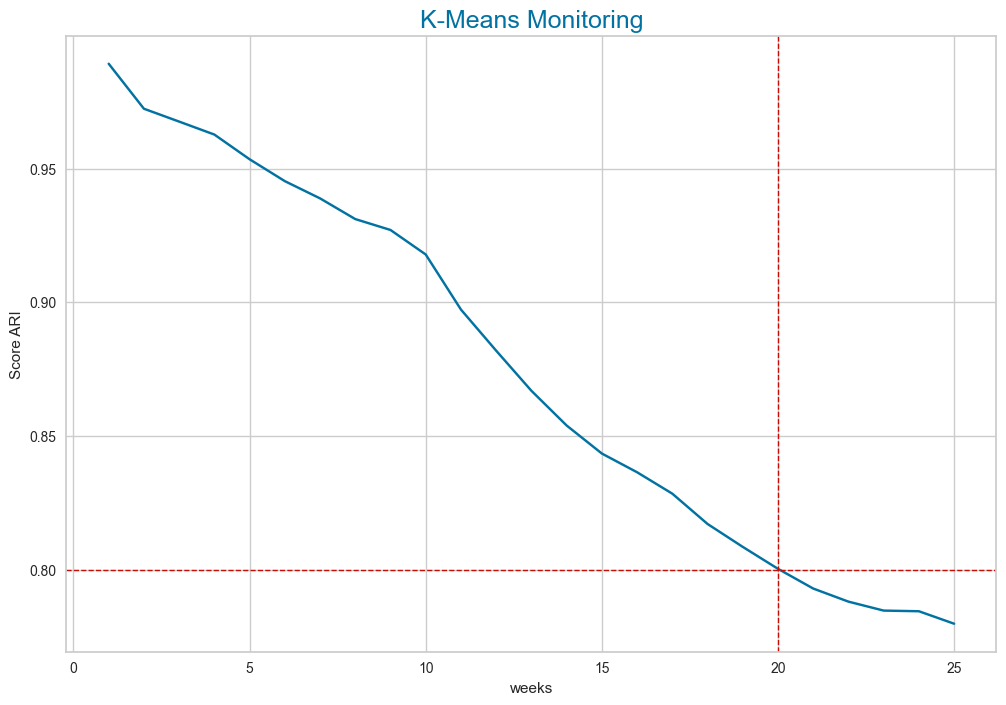

In [9]:
# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari, x=(ari.index+1), y="ARI")
plt.axhline(y=0.8, linestyle="--", 
            color="r",
            xmax=1,
            linewidth=1)
plt.axvline(x=20, linestyle="--", 
            color="r",
            ymax=1,
            linewidth=1)
plt.xlabel("weeks")
plt.ylabel("Score ARI")
plt.title("K-Means Monitoring",
          fontsize=18,
          color="b")
plt.show()